In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import required libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

2021-08-25 15:23:30.773260: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
df_train = pd.read_json('~/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/train.json')
data_train = df_train.T
df_val = pd.read_json('/home/zac/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/val.json')
data_val = df_val.T
df_test = pd.read_json('~/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/test.json')
data_test = df_test.T

In [4]:
data_train['species'] = data_train['genus'] +'_'+ data_train['specific_epithet']

In [5]:
data_val['species'] = data_val['genus'] +'_'+ data_val['specific_epithet']

In [6]:
data_train['full_image_path'] = data_train['image_path'] + '/' + data_train['image_name']

In [7]:
data_val['full_image_path'] = data_val['image_path'] + '/' + data_val['image_name']

In [8]:
data_test['species'] = data_test['genus'] +'_'+ data_test['specific_epithet']
data_test['full_image_path'] = data_test['image_path'] + '/' + data_test['image_name']

In [9]:
sub_data_train = data_train.sample(n=1000, random_state=818)

In [10]:
sub_data_train.shape

(1000, 17)

In [11]:
sub_data_val = data_val.sample(n=200, random_state=818)

In [12]:
sub_data_test = data_test.sample(n=200, random_state=818)

In [13]:
FOLDER_PATH = '../Butterfly_identification/rawdata/ETHEC_dataset/IMAGO_build_test_resized/'

In [14]:
sub_data_train.species.drop_duplicates().count()

248

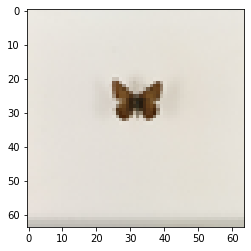

In [15]:
image = Image.open(FOLDER_PATH+sub_data_train.full_image_path[0])
image = image.resize((64,64))
image = np.asarray(image)
plt.imshow(image)

In [16]:
image.size

12288

In [17]:
type(image)

numpy.ndarray

In [18]:
sub_data_train[sub_data_train['species']=='Lycaena_tityrus']

,author,barcode,country,dec_lat,dec_long,family,genus,image_name,image_path,infraspecific_epithet,primary_division,specific_epithet,subfamily,subspecific_epithet,token,species,full_image_path
1a835dcd-0aaa-4cfe-869b-e3c200d63496,"(Poda, 1761)",ETHZ-ENT0013889,Switzerland,47.19515,8.78223,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011697.JPG,2017_04_05R,None,Schwyz,tityrus,Lycaeninae,tityrus,1a835dcd-0aaa-4cfe-869b-e3c200d63496,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011697.JPG
ebb70b82-6e7a-4d00-8cba-f3c6bf52b6cf,"(Poda, 1761)",ETHZ-ENT0013788,Switzerland,45.86666,8.98332,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_04_011573.JPG,2017_04_04R,None,Ticino,tityrus,Lycaeninae,tityrus,ebb70b82-6e7a-4d00-8cba-f3c6bf52b6cf,Lycaena_tityrus,2017_04_04R/ETHZ_ENT01_2017_04_04_011573.JPG
b0f34609-ac6c-45b7-b895-cf6d873ef5b8,"(Poda, 1761)",ETHZ-ENT0013792,Switzerland,46.32502,7.9879,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_04_011577.JPG,2017_04_04R,None,Valais,tityrus,Lycaeninae,tityrus,b0f34609-ac6c-45b7-b895-cf6d873ef5b8,Lycaena_tityrus,2017_04_04R/ETHZ_ENT01_2017_04_04_011577.JPG
38fbda71-0a33-4e44-89e3-261485a70128,"(Poda, 1761)",ETHZ-ENT0013888,Switzerland,47.36749,8.56783,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011695.JPG,2017_04_05R,None,Zurich,tityrus,Lycaeninae,tityrus,38fbda71-0a33-4e44-89e3-261485a70128,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011695.JPG
f9463970-5137-426c-aa89-5089013ade72,"(Speyer, 1851)",ETHZ-ENT0014031,Switzerland,46.793029,9.821343,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011857.JPG,2017_04_05R,None,Grisons,tityrus,Lycaeninae,subalpina,f9463970-5137-426c-aa89-5089013ade72,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011857.JPG
0d7c2d00-7122-4faa-93e2-b677f62806ef,"(Poda, 1761)",ETHZ-ENT0013806,Switzerland,46.24799,8.708,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011596.JPG,2017_04_05R,None,Ticino,tityrus,Lycaeninae,tityrus,0d7c2d00-7122-4faa-93e2-b677f62806ef,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011596.JPG
3de15d03-f1d9-49fc-81ce-efcd4667d97a,"(Poda, 1761)",ETHZ-ENT0013852,Switzerland,47.54228,8.20139,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011653.JPG,2017_04_05R,None,Aargau,tityrus,Lycaeninae,tityrus,3de15d03-f1d9-49fc-81ce-efcd4667d97a,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011653.JPG
c973cf39-a825-488a-afc9-446ce4f77b0b,"(Poda, 1761)",ETHZ-ENT0013799,Switzerland,47.43205,8.5634,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011588.JPG,2017_04_05R,None,Zurich,tityrus,Lycaeninae,tityrus,c973cf39-a825-488a-afc9-446ce4f77b0b,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011588.JPG
8c5a6f76-e513-44d4-b0b4-8af8ec2c3569,"(Poda, 1761)",ETHZ-ENT0013833,Italy,37.316667,13.666667,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011628.JPG,2017_04_05R,None,Sicily,tityrus,Lycaeninae,tityrus,8c5a6f76-e513-44d4-b0b4-8af8ec2c3569,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011628.JPG
4f4f56ce-d159-4084-9186-c66bc1d944b6,"(Poda, 1761)",ETHZ-ENT0013882,Switzerland,46.836111,9.559722,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011685.JPG,2017_04_05R,None,Grisons,tityrus,Lycaeninae,tityrus,4f4f56ce-d159-4084-9186-c66bc1d944b6,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011685.JPG


In [19]:
images_train = []
for image in sub_data_train.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((128,128))
    tmp = np.asarray(tmp)
    images_train.append(tmp)
images_train = np.array(images_train)

In [20]:
images_train.shape

(1000, 128, 128, 3)

In [21]:
images_train[0].shape

(128, 128, 3)

In [22]:
images_val = []
for image in sub_data_val.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((128,128))
    tmp = np.asarray(tmp)
    images_val.append(tmp)
images_val = np.array(images_val)

In [23]:
images_val.shape

(200, 128, 128, 3)

In [24]:
base_model=MobileNetV2(weights='imagenet', input_shape=images_train[0].shape,include_top=False)

2021-08-25 15:23:57.543243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-25 15:23:57.613783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 15:23:57.614790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-08-25 15:23:57.614858: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-25 15:23:57.621726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-25 15:23:57.621794: I tensorflow/stream_executor/pl

In [25]:
base_model.trainable=False

In [26]:
y = sub_data_train['species']
y_val = sub_data_val['species']

In [27]:
y_val.shape

(200,)

In [28]:
images_train.shape

(1000, 128, 128, 3)

In [29]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
'''x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3'''
x=Dense(130, activation = 'relu')(x)

In [30]:
preds=Dense(sub_data_train.species.drop_duplicates().count(),activation='softmax')(x) #final layer with softmax activation for N classes

In [31]:
model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

In [32]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [34]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

In [35]:
y = np.array(y).reshape(1000, 1)
y_val = np.array(y_val).reshape(200,1)

In [36]:
y

array([['Lycaena_tityrus'],
       ['Clossiana_titania'],
       ['Argynnis_paphia'],
       ['Nymphalis_antiopa'],
       ['Cupido_minimus'],
       ['Euphydryas_cynthia'],
       ['Erebia_aethiops'],
       ['Thymelicus_sylvestris'],
       ['Melitaea_didyma'],
       ['Coenonympha_tullia'],
       ['Aricia_artaxerxes'],
       ['Colias_hyale'],
       ['Pieris_bryoniae'],
       ['Pieris_bryoniae'],
       ['Anthocharis_cardamines'],
       ['Plebejus_idas'],
       ['Erebia_triaria'],
       ['Brenthis_daphne'],
       ['Leptidea_sinapis'],
       ['Polyommatus_dorylas'],
       ['Plebejidea_loewii'],
       ['Fabriciana_adippe'],
       ['Erebia_meolans'],
       ['Polyommatus_icarus'],
       ['Lycaena_virgaureae'],
       ['Erebia_mnestra'],
       ['Plebejus_idas'],
       ['Vanessa_cardui'],
       ['Boloria_napaea'],
       ['Lycaena_virgaureae'],
       ['Parnassius_mnemosyne'],
       ['Plebejus_idas'],
       ['Araschnia_levana'],
       ['Maniola_jurtina'],
       ['Colia

In [37]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(y)
y_cat = ohe.transform(y)
y_val_cat = ohe.transform(y_val)



In [38]:
pd.DataFrame(y_val_cat).sum().sum()

167.0

In [39]:
history = model.fit(x = images_train,
         y = y_cat,
         validation_data=(images_val, y_val_cat),
         batch_size = 32,
         epochs = 50,
         callbacks = [es])

2021-08-25 15:24:00.319314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-25 15:24:00.337481: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


Epoch 1/50


2021-08-25 15:24:01.827938: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-25 15:24:02.004504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-08-25 15:24:02.254785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-25 15:24:02.503795: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


32/32 [==============================] - 5s 69ms/step - loss: 5.3220 - accuracy: 0.0550 - val_loss: 4.3291 - val_accuracy: 0.0450
Epoch 2/50
32/32 [==============================] - 1s 43ms/step - loss: 4.6891 - accuracy: 0.1150 - val_loss: 4.0076 - val_accuracy: 0.0500
Epoch 3/50
32/32 [==============================] - 1s 44ms/step - loss: 4.2622 - accuracy: 0.1560 - val_loss: 3.7487 - val_accuracy: 0.0950
Epoch 4/50
32/32 [==============================] - 1s 44ms/step - loss: 3.8856 - accuracy: 0.2140 - val_loss: 3.5265 - val_accuracy: 0.1350
Epoch 5/50
32/32 [==============================] - 1s 43ms/step - loss: 3.5946 - accuracy: 0.2550 - val_loss: 3.3388 - val_accuracy: 0.1600
Epoch 6/50
32/32 [==============================] - 1s 43ms/step - loss: 3.2940 - accuracy: 0.3200 - val_loss: 3.1539 - val_accuracy: 0.1650
Epoch 7/50
32/32 [==============================] - 1s 45ms/step - loss: 3.0463 - accuracy: 0.3360 - val_loss: 3.0532 - val_accuracy: 0.2250
Epoch 8/50
32/32 [======

In [40]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0.5, 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0, 0.8)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

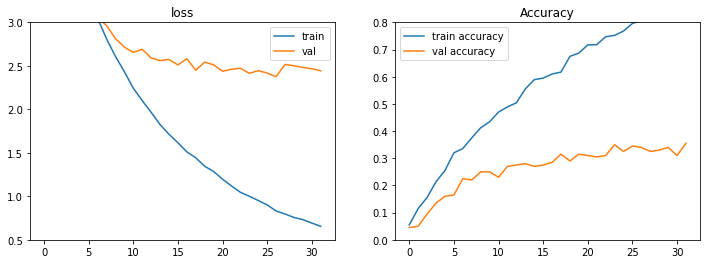

In [41]:
plot_history(history)

In [42]:
images_test = []
for image in sub_data_test.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((128,128))
    tmp = np.asarray(tmp)
    images_test.append(tmp)
images_test = np.array(images_test)

In [43]:
y_test = sub_data_test['species']

In [44]:
y_test = np.array(y_test).reshape(200,1)

In [45]:
y_test_cat = ohe.transform(y_test)

In [46]:
model.evaluate(images_test, y_test_cat)

7/7 [==============================] - 0s 35ms/step - loss: 5.5504 - accuracy: 0.1700


[5.550384998321533, 0.17000000178813934]